## Seleção de Patch de Maneira Dinâmica

In [1]:
from PIL import Image
import numpy as np
import random
random.seed(10)
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
# Realizando abertura da imagem com a bib PILLOW
path_image = "../data/base_recortada/ASC-H/10.png"
im = Image.open(path_image)
im.format, im.size, im.mode

('PNG', (180, 180), 'RGB')

In [3]:
# im = im.rotate(45)

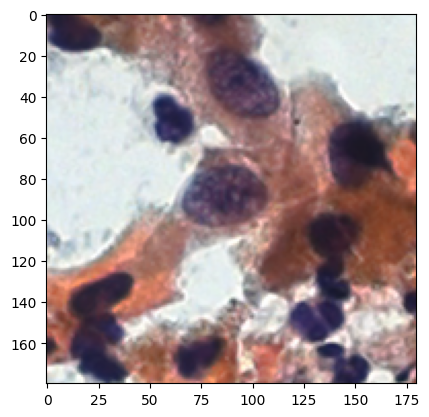

In [4]:
plt.imshow(im)
plt.show()

### Normal Pixels

In [6]:
def visualize_patch_centers(image, centers, patch_size):
    # cria o ax para plotar a img
    fig, ax = plt.subplots(1)
    
    # convert para np
    image_np = np.array(image)
    
    # normaliza a img para intervalo de 0 e 1
    if image_np.max() > 1:
        image_np = image_np / 255.0
    
    ax.imshow(image_np)
    
    patch_height, patch_width = patch_size
    
    for (h, w) in centers:
        rect = patches.Rectangle(
            (w - patch_width // 2, h - patch_height // 2), 
            patch_width, patch_height,
            linewidth=1, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)
        plt.plot(w, h, marker='v', color='r')
    
    # Ajusta limite das imagens para proporcao correta
    ax.set_xlim([0, image_np.shape[1]])
    ax.set_ylim([image_np.shape[0], 0])
    
    plt.show()

196
(8, 8)


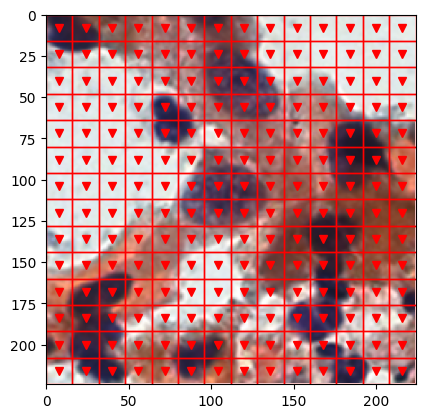

In [6]:
def generate_patch_centers(image_height, image_width, patch_size):
  
    # Stride é o espacamento entre os patches que é o próprio patch_size
    stride = patch_size  
    
    # Qtd de patches na height e no widget (SEM SOBREPOSICAO)
    num_patches_h = image_height // stride
    num_patches_w = image_width // stride
    
    centers_h = []
    centers_w = []
    
    # Todos os patches da coluna
    for i in range(num_patches_h):
      centers_h.append((i * stride + stride // 2))
    
    # Todos os patches da largura
    for j in range(num_patches_w):
      centers_w.append((j * stride + stride // 2))
    
    centers = []
    # Calculando a combinação das posicoes dos patches (X,Y)
    for h in centers_h:
      for w in centers_w:
        centers.append((h,w))
    
    # Retornar os pixels centrais
    return centers

# Variaveis
patch_size = 16
    
# Realizando resize na imagem com a bib PIL para 224x224
resized_image = im.resize((224,224))
centers = generate_patch_centers(224, 224, patch_size)
print(len(centers))
print(centers[0])

# Printa a visualizacao da imagem
visualize_patch_centers(resized_image, centers, (patch_size, patch_size))

-----

### Random Pixels

In [7]:
def generate_random_patch_centers(image_height, image_width, patch_size, num_patches):
    patch_height, patch_width = patch_size
    
    centers = []
    for _ in range(num_patches):
        h = random.uniform(patch_height / 2, image_height - patch_height / 2)
        w = random.uniform(patch_width / 2, image_width - patch_width / 2)
        centers.append((h, w))

    return centers

196
[(126.851739695502, 97.20892337242384), (128.24299063596985, 50.86843228501636), (177.17082028232255, 179.30648548695666), (143.92228705144456, 41.32774775591449), (116.29922680510431, 76.17674481739537), (59.99930875077128, 206.18591710234963), (215.28385444820668, 17.267727549690072), (186.91349575554852, 133.46364708138248), (87.37404507117651, 66.99258932459675), (148.39268820407085, 103.02087942012757), (150.6591889787157, 145.66403457088904), (35.659454100140266, 167.71026530035004), (212.3419557943277, 209.63273736422312), (135.57197867371548, 17.206211635841147), (8.843469984948753, 35.86628562621985), (203.72847245033347, 70.99499690204703), (84.1582851453687, 194.82481886415118), (73.38767143094174, 122.18829427458034), (98.69443918581743, 21.51878863438491), (129.58561494600147, 183.56612271367564), (40.53513502458053, 54.65418548669663), (93.87700320468687, 15.680372764194836), (111.29352771224202, 178.14043580136342), (144.8413152618947, 118.9646170157766), (185.866154

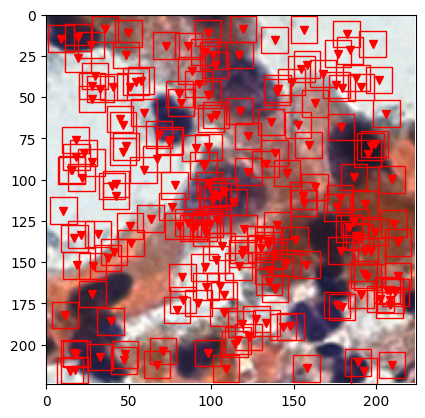

In [8]:
image_height = 224
image_width = 224
patch_size = (16, 16)
num_patches = 196
resized_image = im.resize((224,224))

patch_centers = generate_random_patch_centers(image_height, image_width, patch_size, num_patches)

# patch_centers = patch_centers[0:2]

print(len(patch_centers))
print(patch_centers)
visualize_patch_centers(resized_image, patch_centers, (16, 16))

---

### Random Pixels (Melhorado)

In [ ]:
def pixels_adj(matriz, x, y, n_voltas):
    coords_voltas = []
    n_linhas, n_colunas = matriz.shape
    
    for volta in range(1, n_voltas + 1):
        for i in range(-volta, volta + 1):
            if 0 <= y + i < n_linhas:
                if 0 <= x - volta < n_colunas:
                    coords_voltas.append((y + i, x - volta))
                if 0 <= x + volta < n_colunas:
                    coords_voltas.append((y + i, x + volta))
        
        for j in range(-volta + 1, volta):
            if 0 <= x + j < n_colunas:
                if 0 <= y - volta < n_linhas:
                    coords_voltas.append((y - volta, x + j))
                if 0 <= y + volta < n_linhas:
                    coords_voltas.append((y + volta, x + j))
    coords_voltas.append((y,x))
    return coords_voltas

def verificar_adj(matriz, x, y, lista_centros):
    x, y = int(round(x)), int(round(y))  # Converta para inteiros
    if len(lista_centros) == 0:
        return False
    else:
        for each in lista_centros:
            each_x, each_y = int(round(each[1])), int(round(each[0]))
            ret = pixels_adj(matriz=matriz, x=each_x, y=each_y, n_voltas=8)
            if (y, x) in ret:  # Verifique na ordem correta
                return True
    return False

def random_patchs_melhorados(image_height, image_width, patch_size, num_patches, img_PIL):
    patch_height, patch_width = patch_size
    
    img_gray = img_PIL.convert('L')
    img_mtx = np.array(img_gray)
    
    centers = []
    
    for _ in range(num_patches):
        h = random.uniform(patch_height / 2, image_height - patch_height / 2)
        w = random.uniform(patch_width / 2, image_width - patch_width / 2)
        
        
        check = verificar_adj(img_mtx, w, h, centers)
        
        while check:
            h = random.uniform(patch_height / 2, image_height - patch_height / 2)
            w = random.uniform(patch_width / 2, image_width - patch_width / 2)
            check = verificar_adj(img_mtx, w, h, centers)
        
        centers.append((h, w))
    
    return centers

# Uso do código
image_height = 224
image_width = 224
patch_size = (16, 16)
num_patches = 196
imagem_rgb = im.convert('RGB')
resized_image = imagem_rgb.resize((224, 224))

patch_centers = random_patchs_melhorados(image_height, image_width, patch_size, num_patches, resized_image)

print(len(patch_centers))
print(patch_centers)
visualize_patch_centers(resized_image, patch_centers, (16, 16))

### Geração dos centros pré-treinamento

In [2]:
import random
import numpy as np
import cv2
from PIL import Image

####################################
# Random Pixels Melhorado
####################################
def pixels_adj( matriz, x, y, n_voltas):
  coords_voltas = []
  n_linhas, n_colunas = matriz.shape
  
  for volta in range(1, n_voltas + 1):
      for i in range(-volta, volta + 1):
          if 0 <= y + i < n_linhas:
              if 0 <= x - volta < n_colunas:
                  coords_voltas.append((y + i, x - volta))
              if 0 <= x + volta < n_colunas:
                  coords_voltas.append((y + i, x + volta))
      
      for j in range(-volta + 1, volta):
          if 0 <= x + j < n_colunas:
              if 0 <= y - volta < n_linhas:
                  coords_voltas.append((y - volta, x + j))
              if 0 <= y + volta < n_linhas:
                  coords_voltas.append((y + volta, x + j))
  coords_voltas.append((y,x))
  return coords_voltas

def verificar_adj(matriz, x, y, lista_centros):
    x, y = int(round(x)), int(round(y))
    if len(lista_centros) == 0:
        return False
    else:
        for each in lista_centros:
            each_x, each_y = int(round(each[1])), int(round(each[0]))
            ret = pixels_adj(matriz=matriz, x=each_x, y=each_y, n_voltas=8)
            if (y, x) in ret:  
                return True
    return False

def random_patchs_melhorados( patch_size, num_patches, imagem_tensor):
  
    img_PIL = Image.fromarray((imagem_tensor.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8))

    image_height, image_width = img_PIL.size
    
    patch_height, patch_width = patch_size
    
    img_gray = img_PIL.convert('L')
    img_mtx = np.array(img_gray)
    
    centers = []
    
    for _ in range(num_patches):
        h = random.uniform(patch_height / 2, image_height - patch_height / 2)
        w = random.uniform(patch_width / 2, image_width - patch_width / 2)
        
        
        check = verificar_adj(img_mtx, w, h, centers)
        
        while check:
            h = random.uniform(patch_height / 2, image_height - patch_height / 2)
            w = random.uniform(patch_width / 2, image_width - patch_width / 2)
            check = verificar_adj(img_mtx, w, h, centers)
        
        centers.append((h, w))
    
    print(len(centers))
    
    return centers

In [12]:
import os
from torchvision.datasets import ImageFolder

class CustomImageFolder(ImageFolder):
    def __getitem__(self, index):
        img, target = super().__getitem__(index)

        path = self.imgs[index][0]

        image_name = os.path.basename(path)

        return img, target, image_name 

196
O Nome da imagem é: 10.png
196
[(100.78744829855927, 12.360637689692593), (197.41447981898264, 43.84160334240201), (35.16302764920832, 200.8013653797243), (198.6994563141499, 14.771973017955167), (84.19634543759751, 101.0419025795207), (174.27975003416583, 85.04157358534312), (178.1963029831974, 169.52676447091113), (127.82905022743785, 102.96318605478011), (11.825326414362456, 29.388854617469974), (198.49397894773017, 30.15494808046465), (140.6157735998449, 19.384612911382767), (84.58851732566522, 90.07381997818098), (214.06047247044611, 169.62518443198593), (73.04899886429311, 89.90469357788994), (44.3283066452794, 39.45074062350629), (185.5375644071811, 211.29659707816896), (111.62573427059341, 144.67272502482479), (168.34052820602915, 176.95186352434465), (129.5010536911617, 123.78929172120091), (96.39167183350158, 53.75010453854142), (41.328552065103196, 211.25332237576876), (110.57410463531662, 79.3101909036619), (70.62028783475884, 176.20359023526228), (118.61466990795894, 1

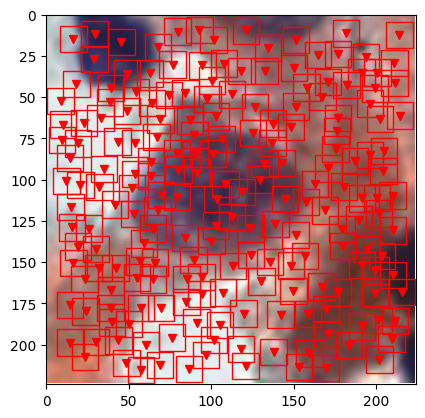

196
O Nome da imagem é: 10000.png
196
[(211.60574248741707, 56.240670718470454), (56.894314794279616, 196.23584456783448), (214.37161649597257, 191.33220360938407), (121.97127396842801, 150.20304059925382), (174.22151235281575, 194.80786415446428), (185.6289121586513, 87.64883936302127), (206.5603646570363, 211.17043755443825), (31.024633065862496, 12.84705922657312), (52.59071222137713, 124.15075970546931), (211.1882120581579, 77.46765802764158), (59.863784321478484, 153.871503414408), (83.95952167043428, 188.7936208771124), (166.98619707458548, 146.22549864184205), (181.45861975572944, 39.2392219897966), (106.48702048471344, 185.05685268872983), (90.43979668559868, 9.619417230908773), (36.65820258568442, 158.3507577290288), (143.12886142040392, 63.82996506271405), (137.17001833486236, 208.51540695632272), (137.6860803083751, 190.91744959773965), (64.49597653421193, 132.3573666802426), (36.68792435676907, 126.53959143004246), (72.80214809901308, 129.31736589314158), (143.4109561693252

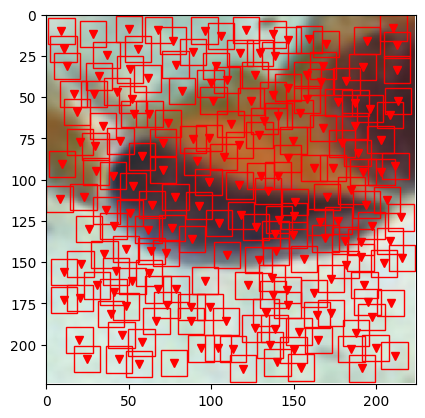

In [15]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import pickle
import numpy as np

pickle_file = "../data/centros_pre_salvos/randomico_melhorado.pkl"

img_size = (224, 224)
batch_size = 32

transform = v2.Compose([
    v2.Resize(img_size),
    v2.ToTensor(),
])

dataset = CustomImageFolder(root="../data/id_base_recortada/", transform=transform)


# lista_centro_dict = []

centros_dict = {}

# Iteração sobre as imagens do dataset
for img_idx in range(2):
    image, label, image_name = dataset[img_idx]  # Carrega a imagem e o rótulo

    centers = random_patchs_melhorados( patch_size=(16,16), num_patches=196, imagem_tensor=image)
    
    
    centros_dict[image_name] = centers
    
    
    im = Image.fromarray((image.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8))
    
    imagem_rgb = im.convert('RGB')
    resized_image = imagem_rgb.resize((224, 224))
    print(f"O Nome da imagem é: {image_name}")
    print(len(centers))
    print(centers)
    visualize_patch_centers(resized_image, centers, (16, 16))
    
# Salvando o dicionário em um arquivo pickle
# with open(pickle_file, 'wb') as f:
#     pickle.dump(centros_dict, f)

# print(f"Centros dos patches salvos em {pickle_file}")

In [11]:
centros_dict

{'10.png': [(112.07574872909235, 144.72014423109937),
  (138.17469415157353, 75.71967072775143),
  (65.2317932597663, 18.90211342854712),
  (149.42224442939477, 67.1075030541324),
  (172.13178068882692, 145.69977453805512),
  (133.672942694691, 198.95495324995935),
  (15.957016688605174, 200.33019360386234),
  (75.70670145620515, 204.96138560528024),
  (17.058190895637416, 78.42829487910873),
  (94.8034526335565, 153.20524668920453),
  (135.2965660752905, 61.9714452266923),
  (90.02522199309969, 47.206425138826),
  (10.643626853933915, 53.03776767774817),
  (69.29513639917113, 184.6358429778094),
  (66.80959302491993, 88.39465853570718),
  (180.45717397479513, 171.2571824221338),
  (214.3975572125142, 11.184509366668173),
  (191.43347606161984, 150.19656801187634),
  (165.65770937619973, 188.85631650297978),
  (26.75107544273341, 142.29123949537092),
  (197.48082491213648, 83.23638570463329),
  (90.08201234617958, 137.4175447345632),
  (168.4921804919085, 51.99270445678919),
  (105.710

In [33]:
with open('../data/centros_pre_salvos/randomico_melhorado.pkl', 'rb') as f:
        testando  = pickle.load(f)
        

In [34]:
len(testando)

43

In [35]:
testando

{'a2af8c70bf25f20ba9dfc5065c981f2d221f6f3eb125db2483599e09d1bf8575': [(91.45420814502222,
   65.20832400832381),
  (14.095469157535204, 130.6026239868358),
  (79.11762607178169, 122.8051516094567),
  (15.74170175900322, 169.0138276526545),
  (21.53140321489603, 106.46159906765496),
  (87.86722761815415, 94.18039623857271),
  (61.47693094418775, 123.44237382823613),
  (19.851009139904576, 190.89995495262747),
  (106.41269086751988, 36.7682450775544),
  (45.81350790363518, 87.77769777320175),
  (213.81342333838575, 14.040269457955704),
  (207.03730633909353, 120.16781569816699),
  (155.78890380911176, 131.82743404207653),
  (15.010654037767777, 82.61357107556064),
  (27.336332821781582, 206.71851918814642),
  (63.11112836633026, 20.561585285137745),
  (98.66532724774642, 145.08107139010428),
  (181.27323895676022, 44.49090174466633),
  (57.058509630942815, 39.502983785972404),
  (21.256793221293123, 19.272881386541115),
  (173.39874320337398, 60.69565732719134),
  (46.683383528975924, 18

In [37]:
image_path = '../data/base_recortada/Negative for intraepithelial lesion/530.png'  # Altere para o caminho da sua imagem

# Carrega a imagem usando PIL
image = Image.open(image_path)

# Define as transformações (opcional, mas comum em tarefas de visão computacional)
transform = v2.Compose([
    v2.Resize((224, 224)),  # Redimensiona a imagem
    v2.ToTensor(),           # Converte a imagem para um tensor
])

# Aplica as transformações
image_tensor = transform(image)

hash_find = gerar_hash_tensor(image_tensor)

# Exibe informações sobre o tensor
print("Shape do tensor da imagem:", image_tensor.shape) 
print("Hash gerado: ", hash_find)

Shape do tensor da imagem: torch.Size([3, 224, 224])
Hash gerado:  488a3e1d689b7625763f3acd531fff354d8ee6fe0824fea625fe20d0dd12b178


d:\AREA_DE_TRABALHO\Faculdade_8_Periodo\TCC\VIT-cric\vit-dynamic-patches\env\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [38]:
testando[hash_find]

[(102.1907880257719, 119.30790016570916),
 (205.3080490651346, 25.728510125049983),
 (112.87006546039834, 146.4517243549747),
 (70.84467167711162, 161.37123450567023),
 (84.79151297628167, 145.9016023127854),
 (160.7828383245573, 144.82256677038075),
 (39.87348932999595, 11.170280220377759),
 (73.59875741846209, 37.392486465387385),
 (16.77136047669177, 82.99265070391648),
 (95.36756381657062, 90.24667338664392),
 (213.50299850875464, 147.38832525173953),
 (21.677446073374973, 165.6019479306981),
 (49.81962381144784, 174.3191648848385),
 (64.03316753628214, 177.10565507481616),
 (147.05606113215512, 151.4668747229801),
 (180.86861695120785, 97.34132288097777),
 (121.47658639924187, 121.18727514625382),
 (184.14504030262725, 107.39841835243749),
 (74.95907128353855, 69.43478122516018),
 (22.572929348828367, 123.20326720673933),
 (99.26767030017048, 72.85965018270872),
 (11.108138868156693, 167.91007134970283),
 (112.3403166876931, 117.93906270473227),
 (40.426649165469144, 158.999907745